# Using a pretrained convnet

In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# **FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
### Extracting features using the pretrained convolutional base**

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = 'D:/c/Desktop/PIAIC/Artificial Intelligent/3rd Quarter/deep learning/sir nasir/Complte chptrs 5 material/workingDirectory'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #feature map
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Defining and training the densely connected classifier

In [32]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [34]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6894 - acc: 0.9980 - val_loss: 0.6865 - val_acc: 0.9930
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6816 - acc: 0.9975 - val_loss: 0.6801 - val_acc: 0.9930
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6754 - acc: 0.9970 - val_loss: 0.6729 - val_acc: 0.9930
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6645 - acc: 0.9975 - val_loss: 0.6668 - val_acc: 0.9930
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6574 - acc: 0.9970 - val_loss: 0.6581 - val_acc: 0.9930
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6484 - acc: 0.9975 - val_loss: 0.6481 - val_acc: 0.9930
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6393 - acc: 0.9975 - val_loss: 0.6398 - val_acc: 0.9930
Epoch 8/30
200

# Plotting the results

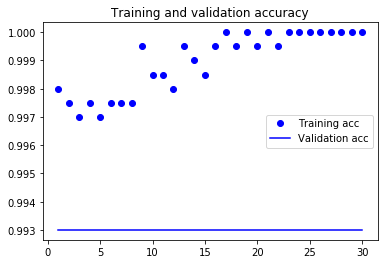

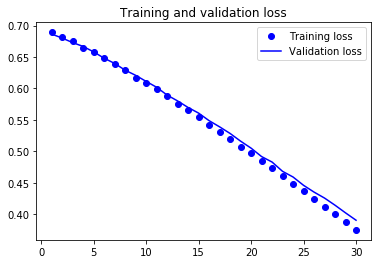

In [35]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# FEATURE EXTRACTION WITH DATA AUGMENTATION
##### Adding a densely connected classifier on top of the convolutional base


In [36]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


# Training the model end to end with a frozen convolutional base


In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [40]:
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

In [41]:
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 283s 3s/step - loss: 0.6031 - acc: 0.6960 - val_loss: 0.4767 - val_acc: 0.8000
Epoch 2/30
100/100 [==============================] - 292s 3s/step - loss: 0.4979 - acc: 0.7805 - val_loss: 0.3528 - val_acc: 0.8420
Epoch 3/30
100/100 [==============================] - 283s 3s/step - loss: 0.4528 - acc: 0.7850 - val_loss: 0.3188 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 283s 3s/step - loss: 0.4174 - acc: 0.8115 - val_loss: 0.3554 - val_acc: 0.8780
Epoch 5/30
100/100 [==============================] - 286s 3s/step - loss: 0.3923 - acc: 0.8300 - val_loss: 0.1599 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 294s 3s/step - loss: 0.3799 - acc: 0.8300 - val_loss: 0.3521 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 308s 3s/step - loss: 0.3630 - acc: 0.8495 - val_loss: 0.1867 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 298s 3s/step - 

# Displaying curves of loss and accuracy during training

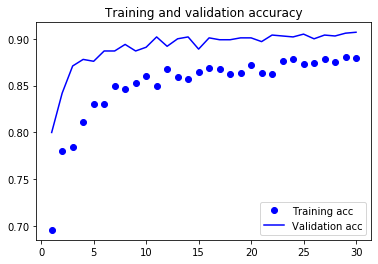

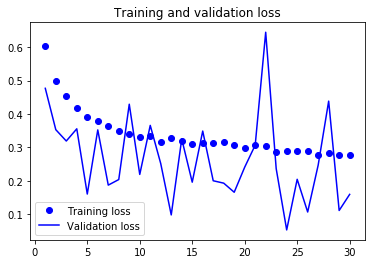

In [42]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [43]:
model.save("Cat_N_Dog_Pretrained.h5")